### Batch Normalization Version 3

##### Target:
Add Batch Normalization in each convolution block except the last layer. The Batch normalization helps to normalize the kernel outputs and helps in better convergence.

##### Results:
1. Parameters:7612
2. Best Train Accuracy: 99.12%
3. Best Test Accuracy: 99.05%

##### Analysis:
1. The Batch normalization helped to normalize the kernel outputs and helps in better convergence. It has pushed the accuracy compared to previous model.
2. Little overfitting
3. Accuracies need to push further to reach target of 99.4%.
4. Use LR Schedulers in the next version.

### import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

### Data Statics

In [2]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./data',train = True,transform=simple_transforms,download=True)
exp_data = dataset.train_data
exp_data = dataset.transform(exp_data.numpy())

print('[Train]')
print('-Numpy Shape:',dataset.train_data.cpu().numpy().shape)
print('-Tensor Shape:',dataset.train_data.size())
print('-min:',torch.min(exp_data))
print('-max:',torch.max(exp_data))
print('-mean:',torch.mean(exp_data))
print('-std:',torch.std(exp_data))
print('-var:',torch.var(exp_data))

[Train]
-Numpy Shape: (60000, 28, 28)
-Tensor Shape: torch.Size([60000, 28, 28])
-min: tensor(0.)
-max: tensor(1.)
-mean: tensor(0.1307)
-std: tensor(0.3081)
-var: tensor(0.0949)


/opt/conda/envs/pytorch/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


 ### Data Transformation

 We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [3]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
     ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

### Create Train and Test Data

In [4]:
train = datasets.MNIST('./data',train=True,transform=train_transforms)
test = datasets.MNIST('./data',train=False,transform=train_transforms)

### Dataloader Arguments

In [5]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available ?:",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True,batch_size = 64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available ?: True


### The Model Architecture

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=8)
    ) #Input size = 28, Output Size = 26, RFout = 3

    #Convolution Block 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=16)
    ) #Input size = 26, Output Size = 24, RFout = 5

    #Transition Block 1
    self.pool1 = nn.MaxPool2d(2,2) #Input size = 24, Output Size = 12, RFout = 6
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=8)
    )#Input size = 12, Output Size = 12, RFout = 6

    #Convolution Block 2
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=16)
    )#Input size = 12, Output Size = 10, RFout = 10
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=32)
    )#Input size = 10, Output Size = 8, RFout = 14

    #Output block
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=10)
    )#Input size = 8, Output Size = 8, RFout = 14
    self.convblock7 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(8,8))
    )#Input size = 8, Output Size = 1, RFout = 28

  def forward(self,x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)



### Check the model parameters

In [7]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
              ReLU-9            [-1, 8, 12, 12]               0
      BatchNorm2d-10            [-1, 8, 12, 12]              16
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
           Conv2d-14             [

Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Train the Model

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
  print("EPOCH:",epoch)
  train(model, device,train_loader,optimizer,epoch)
  test(model,device,test_loader)

EPOCH: 0


Loss=0.31997379660606384 Batch_id=468 Accuracy=88.81: 100%|██████████| 469/469 [00:05<00:00, 91.32it/s] 



Test set: Average loss: 0.2100, Accuracy: 9676/10000 (96.76%)

EPOCH: 1


Loss=0.14059939980506897 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:03<00:00, 118.42it/s]



Test set: Average loss: 0.1206, Accuracy: 9772/10000 (97.72%)

EPOCH: 2


Loss=0.19316790997982025 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:03<00:00, 117.61it/s] 



Test set: Average loss: 0.0849, Accuracy: 9830/10000 (98.30%)

EPOCH: 3


Loss=0.05872929468750954 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:04<00:00, 117.12it/s] 



Test set: Average loss: 0.0865, Accuracy: 9827/10000 (98.27%)

EPOCH: 4


Loss=0.10702186077833176 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:03<00:00, 117.30it/s] 



Test set: Average loss: 0.0605, Accuracy: 9865/10000 (98.65%)

EPOCH: 5


Loss=0.05565832555294037 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:03<00:00, 117.87it/s] 



Test set: Average loss: 0.0623, Accuracy: 9857/10000 (98.57%)

EPOCH: 6


Loss=0.06059025600552559 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:04<00:00, 115.00it/s] 



Test set: Average loss: 0.0535, Accuracy: 9877/10000 (98.77%)

EPOCH: 7


Loss=0.031494010239839554 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:03<00:00, 118.24it/s]



Test set: Average loss: 0.0496, Accuracy: 9880/10000 (98.80%)

EPOCH: 8


Loss=0.07978760451078415 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:04<00:00, 114.51it/s] 



Test set: Average loss: 0.0450, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=0.08569817990064621 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:04<00:00, 116.05it/s] 



Test set: Average loss: 0.0484, Accuracy: 9901/10000 (99.01%)

EPOCH: 10


Loss=0.01873880811035633 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:04<00:00, 116.93it/s] 



Test set: Average loss: 0.0405, Accuracy: 9898/10000 (98.98%)

EPOCH: 11


Loss=0.06151099503040314 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:03<00:00, 117.64it/s] 



Test set: Average loss: 0.0408, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.026937803253531456 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:03<00:00, 117.28it/s]



Test set: Average loss: 0.0373, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.06555623561143875 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:04<00:00, 116.54it/s] 



Test set: Average loss: 0.0407, Accuracy: 9886/10000 (98.86%)

EPOCH: 14


Loss=0.07519697397947311 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:04<00:00, 115.71it/s] 



Test set: Average loss: 0.0362, Accuracy: 9905/10000 (99.05%)



### Loss and Accuracy Plot

Text(0.5, 1.0, 'Test Accuracy')

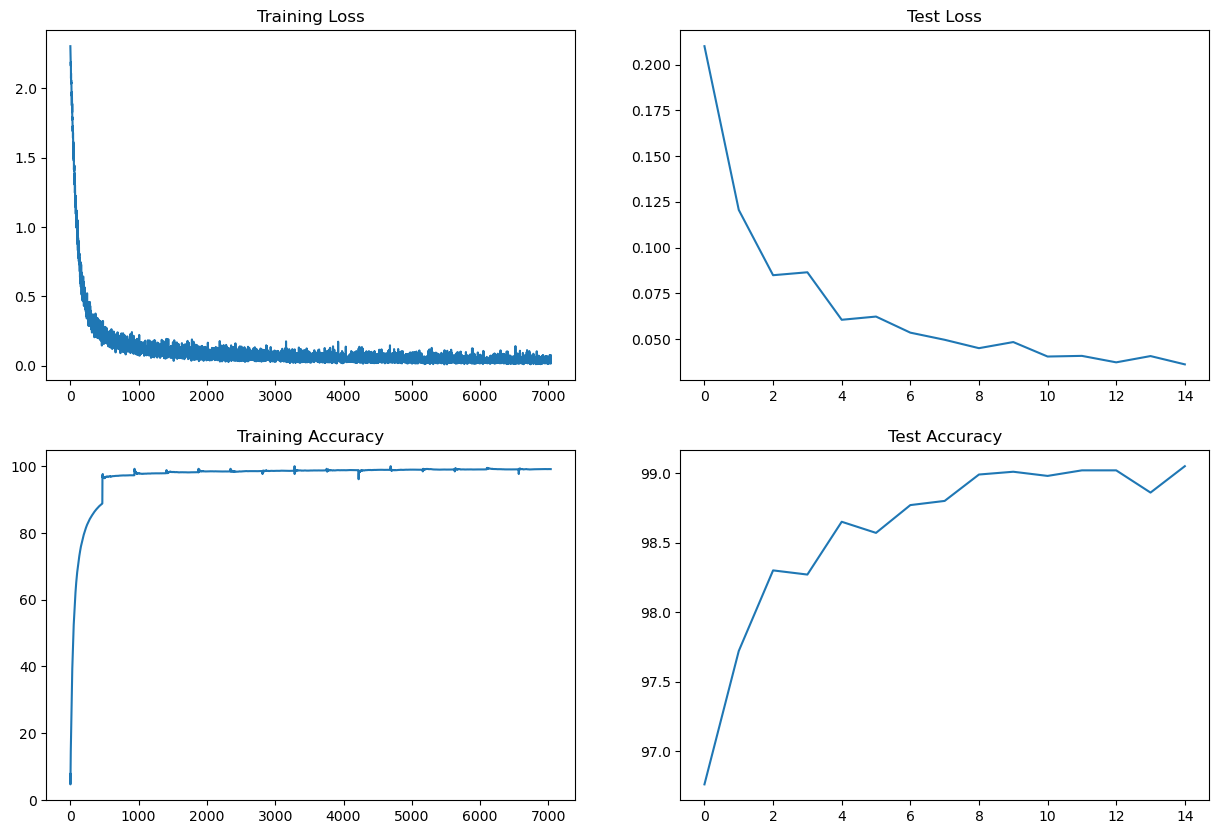

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# Move tensors to CPU and convert to NumPy
train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
train_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_acc]
test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
test_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in test_acc]

axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_cpu)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_cpu)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_cpu)
axs[1, 1].set_title("Test Accuracy")